In [1]:
import os
import math
import numpy as np
from matplotlib import pyplot as py
%matplotlib inline
from scipy import integrate

Read file geometry from the data file

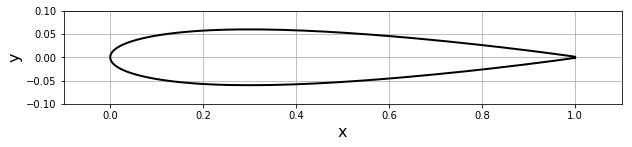

In [2]:
naca_filepath = os.path.join('naca0012.dat')
with open (naca_filepath, 'r') as file_name:
    x, y = np.loadtxt(file_name, dtype=float, delimiter='\t', unpack=True)
    
#plot the geometry

width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color='k', linestyle='-', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1);

Now, we create a discretization of the body geometry into panels.
panels attributes are : starting point, end point, length, and orientation


In [3]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
        
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2 #center point
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2) #length of panel
        
        #orientation of the panel (angle between x-axis and panel normal)
        if xb - xa <= 0.0:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
            
        #location of the panel
        if self.beta <= math.pi:
            self.loc = 'upper'
        else:
            self.loc = 'lower'
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0 # tangential velocity
        self.cp = 0.0 #pressure coefficient

In [4]:
def define_panels(x, y, N=40):
    # descretizes the geometry into panels using the 'cosine' method
    
    R = (x.max() - x.min()) / 2 # radius of the circle 
    x_center = (x.max() + x.min()) / 2 #x-coord of the center
    # define x-xoord of the circle points
    x_circle = x_center + R * np.cos(np.linspace(0.0, 2 * math.pi, N + 1))
    
    x_ends = np.copy(x_circle) # projection of the x-coord on the surface
    y_ends = np.empty_like(x_ends) # initialization of the y-coord numpy array
    
    x, y = np.append(x, x[0]), np.append(y, y[0]) # extend arrays using numpy.append
    
    #computes the y-coordinate of end points
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1]- a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
        
    return panels

Now we can use this function to call with a desired number of panels whenever we execute the cell below.

(-0.1, 0.1)

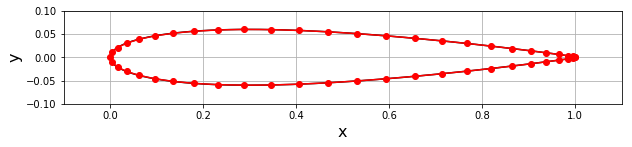

In [5]:
N = 50
panels = define_panels(x, y, N)

#plot the geometry and the panels
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x, y, color = 'k')
py.plot(np.append([panel.xa for panel in panels], panels[0].xa),
        np.append([panel.ya for panel in panels], panels[0].ya),
       marker='o', markersize=6, color='r')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.1)
py.ylim(-0.1, 0.1)

Now, we have to apply freestream conditions. The angle of attack will be 0, and the u_inf speed to be 1. We will create a class called freestream to make our code easier to read and easier to implement.

In [6]:
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)  # turns degrees to radians

In [7]:
# define and create the object freestream
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

Now, we have to enforce the flow tangency boundary condition.
We know that at each control point, the normal velocity will be zero coming out of each panel. This leads us to the equation that we derived in the previous lesson.

We create a function that is generic for both the tangential and normal directions, that way we only have to create one, and we can re-use it for both velocities.

In [8]:
def integral(x, y, panel, dxdz, dydz):
    
    #evaluates the contribution of a single panel at one point.
    
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz + 
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) / 
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2))
    return integrate.quad(integrand, 0.0, panel.length)[0]

Now, we must build the linear system of equations of the form Ax = b, 
and set them to matricies. 

In [9]:
def build_matrix(panels):
    
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                   math.cos(p_i.beta),
                                                   math.sin(p_i.beta))
    return A

def build_b(panels, freestream):
    
    b = np.empty(len(panels), dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    return b

In [10]:
A = build_matrix(panels)        #compute the singularity matrix
b = build_b(panels, freestream) #compute freestream b

In [11]:
# solve the linear system
sigma = np.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = sigma[i]

Now, we get the tangential velocity to find the pressure coefficient

In [12]:
def get_tangent_velocity(panels, freestream):
    #computes tangential velocity on the surface of the panels.
    
    N = len(panels)
    A = np.empty((N, N), dtype=float)
    np.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / math.pi * integral(p_i.xc, p_i.yc, p_j,
                                                  -math.sin(p_i.beta),
                                                  math.cos(p_i.beta))
                
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta
                                  for panel in panels])
    
    sigma = np.array([panel.sigma for panel in panels])
    
    vt = np.dot(A, sigma) + b
    
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [13]:
#compute the tangential velocity at the center-point of each panel
get_tangent_velocity(panels, freestream)

In [14]:
def get_pressure_coeff(panels, freestream):
    #computes the surface pressure coefficients on the panels.
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [15]:
#computes the surface pressure coefficients
get_pressure_coeff(panels, freestream)

Now, using the NASA web server, we can apply the theoretical solution to see just how close our solution is to the legitamite solution. We will simply script the solution into the arrays below.

In [16]:
voverVsquared=np.array([0.0, 0.64, 1.01, 1.241, 1.378, 1.402, 1.411, 1.411,
                       1.399, 1.378, 1.35, 1.288, 1.228, 1.166, 1.109, 1.044, 
                       0.956, 0.906, 0.0])

In [17]:
xtheo = np.array([0.0, 0.5, 1.25, 2.5, 5.0, 7.5, 10.0, 15.0, 20.0, 25.0, 30.0,
                 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 95.0, 100.0])
xtheo /= 100

Now, we plot the results!

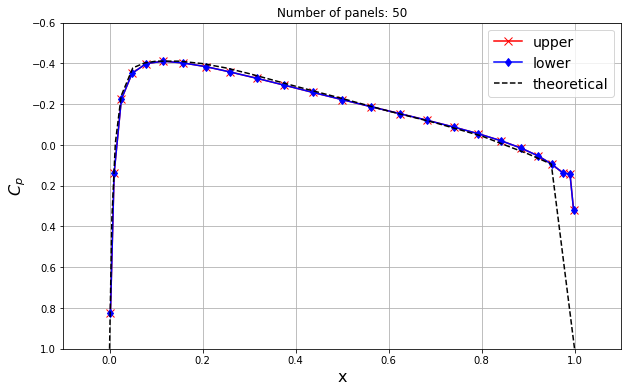

In [18]:
py.figure(figsize=(10, 6))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
        [panel.cp for panel in panels if panel.loc == 'upper'],
        label='upper',
        color='r', marker='x', markersize = '8')
py.plot([panel.xc for panel in panels if panel.loc == 'lower'],
        [panel.cp for panel in panels if panel.loc == 'lower'],
        label='lower', 
        color='b', marker='d')
py.plot(xtheo, 1-voverVsquared, label='theoretical', color='k', linestyle='--')
py.legend(loc='best', prop={'size':14})
py.xlim(-0.1, 1.1)
py.ylim(1.0, -0.6)
py.title('Number of panels: {}'.format(N));

now we can compute an accuracy check. For a closed body, the sum of all the source strengths must be zero. If not, it means the body would be adding or absorbing mass from the flow.

In [19]:
#calculate accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print(accuracy)

0.003548880619023789


Now, we will visualize the flow with plots using our everyday meshgrid that we use literally all the fucking time. Knowing the strength of every panel, we find the x component of velocity by taking derivative of the velocity potential in the x-direction, and the same for y.

In [20]:
def get_velocity_field(panels, freestream, X, Y):
    #computes the velocity field on a given 2D mesh.
    
    #freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * np.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * np.ones_like(X, dtype=float)
    
    # add contribution from each source
    vec_integral = np.vectorize(integral)
    for panel in panels:
        u += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 1.0, 0.0)
        v += panel.sigma / (2.0 * math.pi) * vec_integral(X, Y, panel, 0.0, 1.0)
        
    return u, v

In [21]:
#define the mesh grid
nx, ny = 20, 20 # number of points in the x and y direction
x_start, x_end = -1.0, 2.0
y_start, y_end = -0.3, 0.3
X, Y = np.meshgrid(np.linspace(x_start, x_end, nx),
                   np.linspace(y_start, y_end, ny))

#compute the velocity field on the mesh grid
u, v = get_velocity_field(panels, freestream, X, Y)

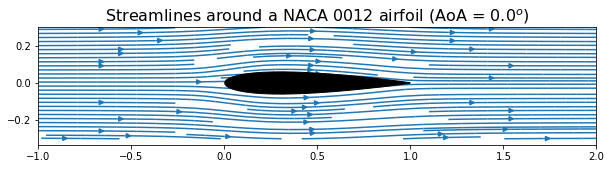

In [22]:
#plot the velocity field
width = 10
py.figure(figsize=(width, width))
py.streamplot(X, Y, u, v)
py.fill([panel.xc for panel in panels],
        [panel.yc for panel in panels], color = 'k', zorder=2)
py.axis('scaled', adjustable='box')
py.title('Streamlines around a NACA 0012 airfoil (AoA = ${}^o$)'.format(alpha), fontsize=16);